In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, AveragePooling2D
from keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from keras.layers import Activation, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.utils import plot_model, to_categorical
from keras import backend as K
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Extact Needed Data

In [4]:
image_directory = 'data/UCMerced_Landuse/Images'
# category_names_all = os.listdir(image_directory)
# print('Total categories: {}'.format(len(category_names_all)))
# for category in category_names_all:
#     print('{}: {}'.format(category, len(os.listdir(image_directory+'/'+category))))

category_names = [
    'agricultural',
    'forest'
]
num_images = 100 # per category
nb_classes = len(category_names)
patch_size = 256
channels = 3

images_orig = []
labels_num = []
for i in range(nb_classes):
    for j in range(num_images):
        img_path = os.path.join(image_directory, category_names[i], category_names[i]+'{:02d}.tif'.format(j))

        # read and resize image
        new_image = plt.imread(img_path)
        resized_image = resize(new_image, (patch_size//4, patch_size//4, channels))
        arr = np.asarray(resized_image)

        images_orig.append(arr)
        labels_num.append([i])
images_orig = np.array(images_orig)
labels_num = np.array(labels_num)
np.save('data/images_orig_2class.npy', images_orig)
np.save('data/labels_num_2class.npy', labels_num)

Divide Dataset

In [5]:
category_names = [
    'agricultural',
    'forest',
]
num_images = 100 # per category
nb_classes = len(category_names)
patch_size = 256
channels = 3

images_orig = np.load('data/images_orig_2class.npy')
labels = np.load('data/labels_num_2class.npy')
# labels = to_categorical(labels_num, nb_classes)

x_train, x_test, y_train, y_test = train_test_split(images_orig, labels, test_size=0.2,
                                                    stratify=labels, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25,
                                                    stratify=y_train, random_state=2023)

Build Model

In [6]:
input_shape = (64, 64, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
prob_drop = 0.5

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same',))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=prob_drop))

model.add(Dense(1, activation='sigmoid'))



epochs = 50
base_learning_rate = 0.0001
batch_size = 32
opt = Adam(learning_rate=base_learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])



print('training ...')
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    verbose=2, validation_data=(x_val,y_val))
print('done')

training ...
Epoch 1/50
4/4 - 1s - loss: 0.7083 - accuracy: 0.4500 - val_loss: 0.6667 - val_accuracy: 0.5000 - 1s/epoch - 317ms/step
Epoch 2/50
4/4 - 0s - loss: 0.6677 - accuracy: 0.5083 - val_loss: 0.6612 - val_accuracy: 0.5000 - 302ms/epoch - 76ms/step
Epoch 3/50
4/4 - 0s - loss: 0.6709 - accuracy: 0.4917 - val_loss: 0.6440 - val_accuracy: 0.5000 - 300ms/epoch - 75ms/step
Epoch 4/50
4/4 - 0s - loss: 0.6676 - accuracy: 0.5250 - val_loss: 0.6327 - val_accuracy: 0.7250 - 299ms/epoch - 75ms/step
Epoch 5/50
4/4 - 0s - loss: 0.6533 - accuracy: 0.6500 - val_loss: 0.6185 - val_accuracy: 0.8750 - 299ms/epoch - 75ms/step
Epoch 6/50
4/4 - 0s - loss: 0.6300 - accuracy: 0.7333 - val_loss: 0.5979 - val_accuracy: 0.7500 - 297ms/epoch - 74ms/step
Epoch 7/50
4/4 - 0s - loss: 0.6261 - accuracy: 0.6250 - val_loss: 0.5849 - val_accuracy: 0.7000 - 299ms/epoch - 75ms/step
Epoch 8/50
4/4 - 0s - loss: 0.6056 - accuracy: 0.6833 - val_loss: 0.5649 - val_accuracy: 0.8750 - 298ms/epoch - 75ms/step
Epoch 9/50
4/

Display History

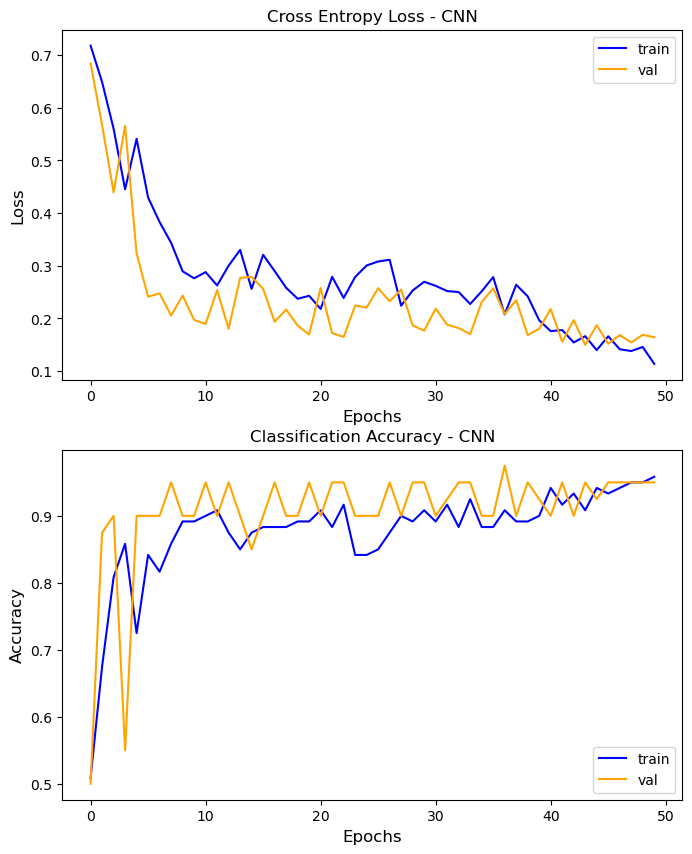

In [7]:
def history_plot(model_id, history):
    plt.figure(figsize=(8,10))
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss - '+model_id, fontsize=12)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy - '+model_id, fontsize=12)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    
    plt.show()

history_plot('CNN', history)

Save Model

In [8]:
MODEL_PATH = 'model/test/'
model.save(MODEL_PATH+'CNN_2class')

INFO:tensorflow:Assets written to: model/test/CNN_2class\assets


INFO:tensorflow:Assets written to: model/test/CNN_2class\assets


Load Model

In [8]:
MODEL_PATH = 'model/test/'
model = load_model(MODEL_PATH+'CNN_2class')

Prediction On Test

In [9]:
print('predicting ...')
prediction = model.predict(x=x_test)
y_pred = (model.predict(x=x_test) > 0.5).astype('int32')

predicting ...
2/2 [==============================] - 0s 8ms/step


Model Metrics

In [10]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

agricultural       0.94      0.85      0.89        20
      forest       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



array([[17,  3],
       [ 1, 19]], dtype=int64)

In [13]:
# ROC AUC
auc = roc_auc_score(y_test, prediction)
print('ROC AUC = %.3f' % (auc))

ROC AUC = 0.987


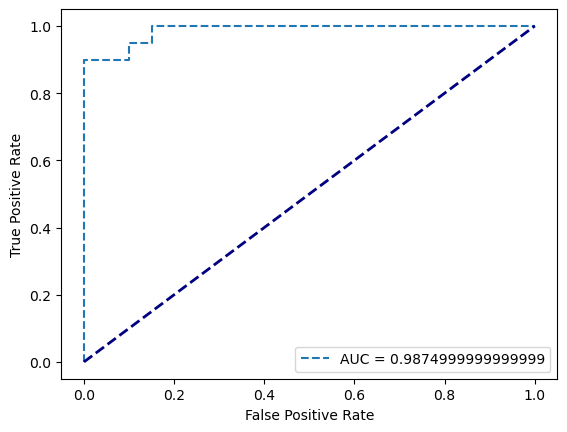

In [15]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, prediction)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='AUC = '+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()